In [1]:
import sys, os
from os.path import join, dirname, abspath
import matplotlib.pyplot as plt
from collections import namedtuple
import numpy as np
plt.rcParams.update({
    "text.usetex": False,
    "ytick.minor.visible":True,
    "xtick.minor.visible":True,
    'xtick.direction': "in",
    'ytick.direction': "in"
})
outdir = "project_2_out"
os.makedirs(outdir,exist_ok=True)
def out(fname): return join(outdir,fname)
def savefig(plot_name): 
    plt.savefig(out(plot_name),bbox_inches="tight",dpi=250)

In [2]:
LOW_LEVEL = 0.06
HIGH_LEVEL = 0.16

Strategy = namedtuple("Strategy", ["m","f","ages"])

PREDATION = Strategy(0.5,0.5,[0.45,0.2,0.35])
TROPHY = Strategy(0.7,0.3,[0.025,0.025,0.95])
RANCHING = Strategy(0.7,0.3,[0.05,0.75,0.20])

In [ ]:
def build_leslie_matrix(birth_rates,survival_rates):
    A = np.zeros((len(birth_rates),len(birth_rates)))
    D = np.diag(survival_rates[:-1],-1)  # along the first diag below the center diag
    A[0,:] = birth_rates
    A += D
    A[-1,-1] = survival_rates[-1]  # add into the corner
    return A

# sanity check
build_leslie_matrix([0.1,0.2,0.3],[0.4,0.5,0.6])

In [ ]:
F = build_leslie_matrix([0,0.35,0.45,0.45,0.45,0.45,0.45,0.45,0.45,0.45,0.45],[0.6,0.9,0.95,0.97,0.97,0.95,0.95,0.95,0.7,0.8,0])
F

In [ ]:
M = build_leslie_matrix(np.zeros(10),[0.6,0.8,0.95,1,1,1,1,0.75,0.34,0])
M

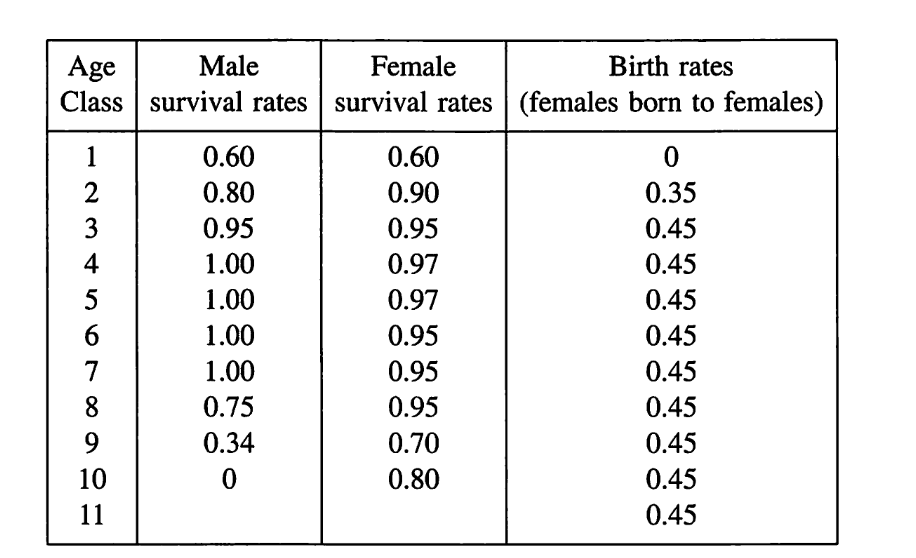

In [6]:
def iterate(r_k,strategy,f_1,m_1,F,M,carrying):
    # overall kill rate (6 or 16), male kill proportion, female kill proportion, kill age breakdown (3x1), prev male pop, prev female pop
    r_f, r_m = strategy.f, strategy.m
    K = strategy.ages
    assert r_m + r_f == 1

    # birth rates linearly decrease if adult male : non-juvenile female ratio drops below 3
    birth_modifier = min(3*(np.sum(m_1[5:])/np.sum(f_1[1:])),1) if np.sum(m_1[5:]) != 0 else 0    

    total_pop = np.sum(f_1) + np.sum(m_1)

    # birth_modifier *= (1-total_pop/carrying)   # logistic growth
    
    F_prime = np.array(F,copy=True)
    F_prime[0,:] *= birth_modifier

    # build kill age distr matrix for females
    K_f = np.zeros_like(f_1)
    K_f[0] = K[0]  # class 1 is juveniles
    K_f[np.arange(1,5)] = K[1]/4
    K_f[np.arange(5,11)] = K[2]/6

    # build kill age distr matrix for males
    K_m = np.zeros_like(m_1)
    K_m[0] = K[0]  # class 1 is juveniles
    K_m[np.arange(1,5)] = K[1]/4
    K_m[np.arange(5,10)] = K[2]/5

    # apply female birth and survival
    f = F_prime@f_1   # females do advancement and birth
    
    b = F_prime[0,:]@f_1 # figure out total num of births, so can apply to males
    B = np.zeros_like(m_1)  # male birth vector
    B[0] = b   # number of new males = number of new females

    # apply male birth and survival
    m = M@m_1 + B

    # NOW calculate how many to kill
    total_pop = np.sum(m)+np.sum(f)
    total_killed = r_k * total_pop

    f -= r_f * K_f * total_killed
    m = m - r_m * K_m * total_killed

    f = np.maximum(f,np.zeros_like(f))
    m = np.maximum(m,np.zeros_like(m))

    return f,m

def run_model(r_k,strategy,f0,m0,F,M,carrying,n,delay=0):
    f, m = f0, m0
    f_arr, m_arr = [], []
    if delay:
        f_arr2, m_arr2 = run_model(0,strategy,f0,m0,F,M,carrying,n=delay,delay=0)
        f, m = f_arr2[-1], m_arr2[-1]
        f_arr,m_arr = list(f_arr2), list(m_arr2)  # to avoid doubling up at the transition
    else:
        f_arr, m_arr = [f0], [m0]
    for _ in range(n-delay):
        f, m = iterate(r_k,strategy,f,m,F,M,carrying)
        f_arr.append(f)
        m_arr.append(m)
    return np.array(f_arr), np.array(m_arr)

In [7]:
steps = 100

carrying = 500

f0 = np.zeros(11)
f0.fill(110*1/11)

m0 = np.zeros(10)
m0.fill(110*1/10)

MANAGEMENT_DELAY = 15

In [8]:
def plot_simulation(f_arr,m_arr,kill_level:str,kill_strategy, delay):
    variant_title = f"{kill_level} {kill_strategy}"
    
    # pop plot
    plt.plot(np.sum(f_arr,axis=1), label="Female")
    plt.plot(np.sum(m_arr,axis=1), label="Male")
    plt.title(variant_title)
    plt.xlabel("t, Years")
    plt.ylabel("Impala Population")
    if delay:
        plt.vlines(delay,*plt.ylim(),linestyles="dashed",color="red",alpha=0.75)
    _=plt.legend()

    # age proportions
    fig,axes = plt.subplots(1,2,sharex=True,sharey=True)
    fig.tight_layout()

    female_ages = [[0],np.arange(1,5),np.arange(5,11)]
    male_ages = [[0],np.arange(1,5),np.arange(5,10)]

    for arr, ages, title, ax in zip([f_arr,m_arr],[female_ages,male_ages],["Female","Male"],axes):
        prev_y = [np.zeros_like(arr[:,0])]
        for age_range,label in zip(ages,["Juvenile","Sub-Adult","Adult"]):
            y = np.sum(arr[:,age_range],axis=1) + prev_y[-1]
            l=ax.plot(y)
            ax.fill_between(np.arange(len(y)),y,prev_y[-1],label=label)
            prev_y.append(y)
        ax.legend()
        ax.set_title(title)
        ax.set_box_aspect(1)

    axes[0].set(ylabel= "Population", xlabel="Time (yrs)")
    axes[1].set(xlabel="Time (yrs)")
    fig.suptitle(f"Impala Population by Age: {variant_title}",y=0.9)

    # age populations
    fig,axes = plt.subplots(1,2,sharex=True,sharey=True)
    fig.tight_layout()

    female_ages = [[0],np.arange(1,5),np.arange(5,11)]
    male_ages = [[0],np.arange(1,5),np.arange(5,10)]


    for arr, ages, title, ax in zip([f_arr,m_arr],[female_ages,male_ages],["Female","Male"],axes):
        prev_y = [np.zeros_like(arr[:,0])]
        for age_range,label in zip(ages,["Juvenile","Sub-Adult","Adult"]):
            y = np.sum(arr[:,age_range],axis=1)/np.sum(arr,axis=1) + prev_y[-1]
            l=ax.plot(y)
            ax.fill_between(np.arange(len(y)),y,prev_y[-1],label=label)
            prev_y.append(y)
        ax.legend()
        ax.set_title(title)
        ax.set_box_aspect(1)

    axes[0].set(ylabel= "Fraction of Population", xlabel="Time (yrs)")
    axes[1].set(xlabel="Time (yrs)")
    fig.suptitle(f"Impala Population Age Distribution: {variant_title}",y=0.9)

# Trophy Hunting

## Low

In [ ]:
f_low_trophy, m_low_trophy = run_model(LOW_LEVEL,TROPHY,f0,m0,F,M,carrying,steps,MANAGEMENT_DELAY)
plot_simulation(f_low_trophy,m_low_trophy,"Low","Trophy Hunting",MANAGEMENT_DELAY)

## High

In [ ]:
f_high_trophy, m_high_trophy = run_model(HIGH_LEVEL,TROPHY,f0,m0,F,M,carrying,steps,MANAGEMENT_DELAY)
plot_simulation(f_high_trophy,m_high_trophy,"High","Trophy Hunting",MANAGEMENT_DELAY)

# Predation

## Low

In [ ]:
f_low_predation, m_low_predation = run_model(LOW_LEVEL,PREDATION,f0,m0,F,M,carrying,steps,MANAGEMENT_DELAY)
plot_simulation(f_low_predation,m_low_predation,"Low","Predation",MANAGEMENT_DELAY)

## High

In [ ]:
f_high_predation, m_high_predation = run_model(HIGH_LEVEL,PREDATION,f0,m0,F,M,carrying,steps,MANAGEMENT_DELAY)
plot_simulation(f_high_predation,m_high_predation,"High","Predation",MANAGEMENT_DELAY)

# No Management

In [ ]:
f_no_manage, m_no_manage = run_model(0,TROPHY,f0,m0,F,M,carrying,n=steps)
plot_simulation(f_no_manage,m_no_manage,"No","Management",0)

# Ranching

## Low

In [ ]:
f_low_ranching, m_low_ranching = run_model(LOW_LEVEL,RANCHING,f0,m0,F,M,carrying,n=steps,delay=MANAGEMENT_DELAY)
plot_simulation(f_low_ranching,m_low_ranching,"Low","Ranching",MANAGEMENT_DELAY)

## High

In [ ]:
f_high_ranching, m_high_ranching = run_model(HIGH_LEVEL,RANCHING,f0,m0,F,M,carrying,n=steps,delay=MANAGEMENT_DELAY)
plot_simulation(f_high_ranching,m_high_ranching,"High","Ranching",MANAGEMENT_DELAY)